In [324]:
from typing import Protocol
import sys
import queue
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import igraph as ig

from src import graphs
from src import cache

Note, I tried using numba to accelerate computations. It provided some benefits in some circumstances.
However, overall, numba is hard to work with because of inconsistent support of different
language features of python and numpy. Working around the limitations often eliminates
any benefit.

In [34]:
print(f"python: {sys.version.rsplit('|')[0]}")
print(f"numpy: {np.__version__}")

python: 3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
numpy: 1.26.4


In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
plt.rcParams["figure.figsize"] = [14,6]
sns.set()

In [37]:
sqlite_path = "data/configurations.sqlite"
pickle_dir = "./data/configurations"

# Whether to refresh expensive cached computations
refresh = False

# Chainweb Configurations

### Cuts

Intuitively a *Cut* of a chainweb is a set of blocks, one from each chain, that can occure concurrently as state of consensus.

Let $\mathcal{C}$ be the set of chains in a chainweb with chain graph $\mathcal{G} = (\mathcal{C}, \mathcal{E})$.
We denote the (symmetric) adjacency matrix of $\mathcal(G)$ as $\mathcal{M}(\mathcal{G})$.

(Note, that we generally distinguish between the chain graph and the chainweb graph. The vertexes of
the former is the set of all chains and it defines the
dependencies between chains and constrains the braiding of a chainweb. The vertex that of the latter
are all the blocks in a chainweb and it represents the direct dependencies between blocks.)

For a chainweb let $\mathcal{B}$ the set of blocks.

A \emph{cut} is a selection of blocks with 
1.  exactly one block from each chain such that
2.  blocks from neighboring chains are braided correctly and are at most one block appart in height.

Formally, a cut $C : \mathcal{C} \to \mathcal{B}$ is a mapping from chains to blocks such that for each $c \in \mathcal{C}$
it holds that
1.  $chain(C(c)) = c$ (block are mapped from their respective chain) and
2.  for all $d \in \mathcal{C}$ with $\{c,d\} \in \mathcal{E}$ it holds that
    1.  $parent_d(C(c)) = C(d)$, or
    2.  $C(c) = parent_c(C(d))$, or
    3.  $parent_d(C(c)) = parent(C(d))$ and $parent(C(c)) = parent_c(C(d))$.
 
In the following we only consider correctly braided chainwebs without forks.
In that case the second can be simplfied to
*   $\left|height(C(c)) - height(C(d))\right| \leq 1$.

### Configurations

Configurations form an equivalence relation on the cuts of a chainweb. A configuration abstracts 
from concrete blocks and considers only on the relative height differences of the blocks in a cut.

Given a cut $C$ the corresponding configuration is defined as the (skew symmetric) square matrix $Conf(C)$,
with

$$
Conf(C) = \left(height(C(c)) - height(C((d)))\right)_{c,d \in \mathcal{C}}\,.
$$

Note that the entries are bounded by the length of the shortest path between the respective
chains in $\mathcal{G}$.

From now on we are going to ignore Cuts and use the variable $C$ to denote a configuration.

Because chainweb graphs are are connected, a single row (or column) of a height different matrix determines
all other rows (or column). A representation can thus pivot on the height difference
vector for a single chain.

Mining a chain increases all entries of the respective row and decreases all entries of the
respective column (note that the values on the diagonal remain unchanged, i.e. are always zero).

$$
mine(C, c) =
\begin{cases}
    C_{i,j} + 1\,, \text{ for } i\neq j \wedge i = c\,, \\
    C_{i,j} - 1\,, \text{ for } i\neq j \wedge j = c\,, \\
    C_{i,j}, \text{ otherwise}\,.
\end{cases}
$$

A chain $i$ has a dependency on a neighboring chain $j$ with $\{i, j\} \in \mathcal{E}$, if
the entry of $j$ in row $i$ is larger than zero, or, generally, if in any row the entry for $j$ is
larger than the entry for $i$.

A chain $c$ is minable in a configuration $C$ if $c$ has no dependency on any of its neighboring chains.

$$
minable(C, c) \text{ iff } \forall i \in \mathcal{C}, \{c, d\} \in \mathcal{E}, C_{i,c} \leq C_{i, d}
$$

We also use the function $minable$ to designate the set of chains that are minable in a configuration $C$:

$$
minable(C) = \{c \in \mathcal{C} \mid| minable(C,c) \}
$$

Note, that the definition of a configuration and the minining function does not depend on the graph. Only
the definition of minability is constrained by the chain graph $\mathcal{G}$.

A configuration $D$ is reachable from a configuration $C$ if there exists a sequence $(c_i)_{i \in \mathbb{\N}}$
of chains $c_i \in \mathcal{C}$, such that $ FIXME

The empty configuration $I$ is the unique configuration in which all chains are minable. This configuration
is defined as the initial configuration.

$I_{i,j} = 0\, \text{ for all } $i,j \in \mathcal{C}$

Since, there are only finitely many configurations, we obtain a finite automaton that models the
transition between configurations that are reachable from the intial configuration.

$$
\mathcal{A} = \left( reachable(I),  \right)
$$


### Configuration Markov Chain:

Each transition to a new configuration corresponds to exactly one minable chain.
In a chainweb the overall hash power is evenly distributed over all minable chains. For the purpose
of this document we also assume that the overall hash power is constant.

We can therefore assign to each outgoing transition in the configuration automaton a probability,
where the probalities for the outgoing transitions of a given configuration are uniformily distributed.

TODO: define $P$

Each configuration that is reachable from the empty configuration can also reach the empty configuration.
(Note, that the state space of the Markov chain is defined to only contain configurations that are
reachable from the initial configuration.)
From this is follows that the Markov chains is irreducible.

To see this, note that mining a particular chain can only block this chain itself. It may unblock
neighboring chains, but it can not cause any other chain to become blocked. As a consequence the 
empty configuration can be reached at any point by stopping to mine on chains that are furthest ahead
and letting other chains catch up until all chains are at the same height.

This also directyly implies that all reachable configurations are minable. Another reason is that

Representation of Configurations as DAGs:

In particular, the entries for neiboring vertexes are either 1, -1, or 0 and 
$Conf(C) \mathcal{M}(\mathcal{G})$ contains only entries of those values.

TODO: the conf is determined by the entries for neighboring nodes. Only one value (0 or 1) per pair
is needed.

A chain is minable if it is not ahead of any direct neighbor chain. Each configuration corresponds to an
acyclic directed subgraph of $\mathcal{G}$ (the reverse is not true). 
A chain is mineable when there are no incoming edges.

A configuration can be obtained from another configuration by mining a mineable chain. A chain is mined by

*   removing all incoming edges of the chain and
*   adding outgoing edges for each edge in $\mathcal{G}$ that is not in the configuration.

Note that if the original graph was acyclic, then the resulting graph is acyclic, too, because the source of
all new edges has no incoming edges. Hence, the result of mining a minable chain on a configuration is indeed
a configuration.

Since, there are only finitely many configurations, we obtain a finite automaton that models the transition between
configurations.

The empty configuration is the unique configuration in which all chains are minable. This configuration
is defined as the initial configuration.

Each configuration that is reachable from the emtpy configuration can also reach the empty configuration.
(Note, that the state space of the Markov chain is defined to only contain configurations that are
reachable from the initial configuration.)
From this is follows that the Markov chains is irreducible.

To see this, note that mining a particular chain can only block this chain itself. It may unblock
neighboring chains, but it can not cause any other chain to become blocked. As a consequence the 
empty configuration can be reached at any point by stopping to mine on chains that are furthest ahead
and letting other chains catch up until all chains are at the same height.

This also directyly implies that all reachable configurations are minable. Another reason is that
a non-minable configuration would necessarily contain a cyclic dependency.

TODO: can we provide an algebra? What are the group equations for the automaton?

TODO: can we derive the quotient automaton with respect to the number of minable chains?

Each transition changes the number of minable chains by $[-1, diameter many chains]$. That
determines the diameter of the automaton and the length of cycles.

### Continuous-Time Markov Chain on Configurations

We assume that the overall hash power is constant and evenly distributed over all minable chains. Each transition
to a new configuration corresponds to exactly one minable chain.

The overall holding time for each configuration is thus distributed evenly across all minable chains. Therefore
the transition rate between configurations is either the overall rate multiplied by the number of minable chains
if there is a transition or 0 when there is no transition between the configurations.

Overall, the transition between configurations can be modeled as a continuous-time Markov chain (CTMC) where the
entries of the q matrix are either 0 or the number of minable chain in the source configuraton multiplied by
the constant overall block rate of the chainweb.

The initial configuration of the system is the empty configuration.

Our goal is to analyize:

*   How much time is spent in each configuration?
*   How much time is spent on configurations with a given number of minable chains?
*   For a given graph, how much time is spent on each chain? How is it distributed?
*   What properties of the graph affect the distribution of time spent on each chain.
*   Do all chains receive equal amounts of hash power?

*   What are possible mining strategies? Should mining rewards depend on the hash power
    that a chain receives? Or is that not needed? (or does chain selection for miners
    involves a prisoner dilemma situation?)


# Performance

Across all chains the network produces on average 1 block height per 30 seconds, i.e. 2 blocks per minute.

Due to the probabilistic nature of the block production process, chains do not advance evenly. As some chains advance and other
fall behind, chains get become blocked.

The amount of available hash power is constant and is distributed evenly across the unblocked chains. Hence the hash power that 
each configuration receives is the same. Similarly, each chain receives the same amount of hash power. 
However, depending on the number of blocked chains, the hash power is concentrated on a samller number of chains and hence that
time spent on a configutration is shorter the more chains are blocked.

# Chainweb Graph

We require the graph to be simple and represent it as adjacency matrix.
(We choose a dense representation, because that turned out to be the most efficient with our implementation.)

In [90]:
def mk_graph(graph):
    g = np.array(graph.get_adjacency(), dtype=np.int8)
    np.fill_diagonal(g, 0)
    return g

def order(g : np.ndarray) -> int:
    return g.shape[0]

# Implementations

In [91]:
class Implementation[Conf, Graph](Protocol):
    @staticmethod
    def mk_graph(graph : ig.Graph) -> Graph:
        pass

    @staticmethod
    def initial(g : Graph) -> Conf:
        pass

    @staticmethod
    def hash(c : Conf) -> int:
        pass

    @staticmethod
    def mine(g : Graph, c : Conf, i : int) -> Conf:
        pass

    @staticmethod
    def minable(g : Graph, c : Conf) -> list[int]: 
        pass

In [92]:
# Generic helper functions

def init_conf1(g):
    return np.zeros(order(g), dtype=np.int8)

def init_conf2(g):
    return np.zeros((order(g), order(g)), dtype=np.int8)
    
def hash_conf(c : np.ndarray) -> int:
    return hash(c.data.tobytes())

### Height Difference Vector Representation

In [ ]:
# This representation exploits the fact that a single row and/or column uniquely determines
# all other rows and/or columns in the matrix.
#
# We pivot on row zero.
#
# Mining chain zero means to increment the first row expect
# for index zero.
# Mining any other chain means to decrement the respective column
# of row zero.
#
# Note that the first entry is always zero. We could remove the
# column and adjust the algorithm, but the benefits are to small to
# justify the added complexity.

# Checking minability:
# 1. mask c with each row of g to focus on neighbors
# 2. check that the maximum entry for each row does not
#    exceed the respective value for the row in c.
    
class HeightDifferenceVector(Implementation):

    @staticmethod
    def mk_graph(graph):
        return mk_graph(graph)

    @staticmethod
    def hash(c):
        return hash_conf(c)

    @staticmethod
    def initial(g):
        return init_conf1(g)

    @staticmethod
    def minable(g, c):
        return (np.where(g, c, -c.shape[0]).max(axis=1) <= c).nonzero()[0]
        # slower
        # return (np.broadcast_to(c, g.shape).max(axis=1, where=(g == 1),initial = -c.shape[0]) <= c).nonzero()[0]

    pivot = 0

    @staticmethod
    def mine(_g, c, i):
        r = c.copy()
        if i == HeightDifferenceVector.pivot:
            r[1:] += 1
        else:
            r[i] -= 1
        return r

# Configuration Automaton

In [ ]:
type ConfsType[C] = dict[int, tuple[int, C, list[int]]]

def mk_confs[Conf, Graph](impl : Implementation[Conf, Graph], graph : ig.Graph) -> ConfsType[Conf]:
    g = impl.mk_graph(graph)
    q = queue.SimpleQueue()
    
    confs={}
    confs : ConfsType[Conf]

    # add initial configuration to queue
    idx = 0
    i = impl.initial(g)
    h = impl.hash(i)
    confs[h] = (idx, i, [])
    q.put(h)

    while not q.empty():
        h = q.get()
        _, c, s = confs[h]
        for i in impl.minable(g, c):
            c_ = impl.mine(g, c, i)
            h_ = impl.hash(c_)
            if not h_ in confs:
                idx += 1
                h_idx = idx
                confs[h_] = (h_idx, c_, [])
                q.put(h_)
            else:
                assert (confs[h_][1] == c_).all()
                h_idx = confs[h_][0] 
            s.append(h_idx)
    return confs

# Note that pickling pandas is very slow.
def mk_confs_df[C](confs : ConfsType[C]) -> pd.DataFrame: 
    print(f"mk_confs_df: {len(confs)}"
    df = pd.DataFrame(
        data = [ (i, c, t, len(t)) for (_h, (i, c, t)) in confs.items() ],
        columns=[ 'idx', 'conf', 'transitions', 'n'],
    )
    assert (df.index == df.idx).all()
    df.drop(columns=['idx'], inplace=True)
    print(f"mk_confs_df done")
    return df

@cache.cached(pickle_dir, "mk_transitions", refresh = refresh)
def mk_transitions[Conf, Graph](impl : Implementation[Conf, Graph], graph : ig.Graph) -> pd.DataFrame:
    return mk_confs_df(mk_confs(impl, graph))


### Configuration Automaton For Petersen

In [308]:
refresh = True

In [313]:
%time petersen_confs_hdv = mk_transitions(HeightDifferenceVector, graphs.Petersen, cache_suffix='petersen_hdv')
len(petersen_confs_hdv)

CPU times: user 70.6 ms, sys: 11.1 ms, total: 81.7 ms
Wall time: 75.7 ms


2613

In [311]:
petersen_confs_hdv

,conf,transitions,n
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",10
1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[11, 12, 13, 14, 15, 16, 17, 18, 19]",9
2,"[0, -1, 0, 0, 0, 0, 0, 0, 0, 0]","[11, 20, 21, 22, 23, 24, 25, 26, 27]",9
3,"[0, 0, -1, 0, 0, 0, 0, 0, 0, 0]","[12, 20, 28, 29, 30, 31, 32, 33, 34]",9
4,"[0, 0, 0, -1, 0, 0, 0, 0, 0, 0]","[13, 21, 28, 35, 36, 37, 38, 39, 40]",9
...,...,...,...
2608,"[0, 1, 1, 0, 2, 0, 0, 0, 0, 1]",[787],1
2609,"[0, 0, -1, 1, -1, -1, -1, -1, 0, -1]",[896],1
2610,"[0, -1, 1, -1, 0, -1, -1, 0, -1, -1]",[864],1
2611,"[0, 2, 0, 1, 1, 0, 1, 0, 0, 0]",[774],1


In [314]:
petersen_confs = petersen_confs_hdv

In [316]:
petersen_confs.groupby('n')['conf'].count()

n
1      10
2     105
3     420
4     790
5     732
6     360
7     140
8      45
9      10
10      1
Name: conf, dtype: int64

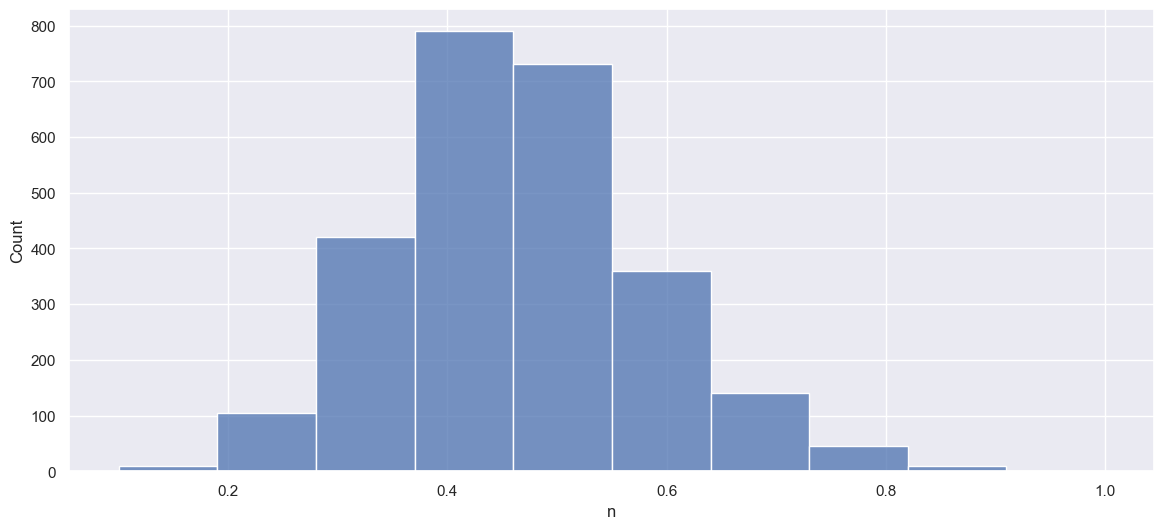

In [317]:
sns.histplot(petersen_confs.n / 10, bins=10)
plt.show()

### Configuration Automaton For Twenty

In [319]:
# Pickling with gzip compression is extremly slow, about 30min for 6GB (resulting in 600MB).
# Just pickling without compresssion takes about 1min.
# Just recomputing the data takes about 6min
# Loading from disk takes only 40s.
# storing the columns uncompressed as numpy arrays is in the order of seconds.
#
# reading is always fast.
#
# TODO find out whether df.to_pickle and pickle.dump are equivalent.
#
%time twenty_confs_hdv = mk_transitions(HeightDifferenceMatrix, graphs.Twenty, cache_suffix='twenty_hdv', cache_refresh=False)
len(twenty_confs_hdv)

CPU times: user 26 s, sys: 508 ms, total: 26.5 s
Wall time: 27.1 s


13238551

In [320]:
twenty_confs = twenty_confs_hdv

In [321]:
twenty_confs.groupby('n').conf.count()

n
1          20
2         710
3       10140
4       76705
5      344884
6      993050
7     1946140
8     2726790
9     2817200
10    2174600
11    1264930
12     570420
13     213360
14      71260
15      21406
16       5545
17       1180
18        190
19         20
20          1
Name: conf, dtype: int64

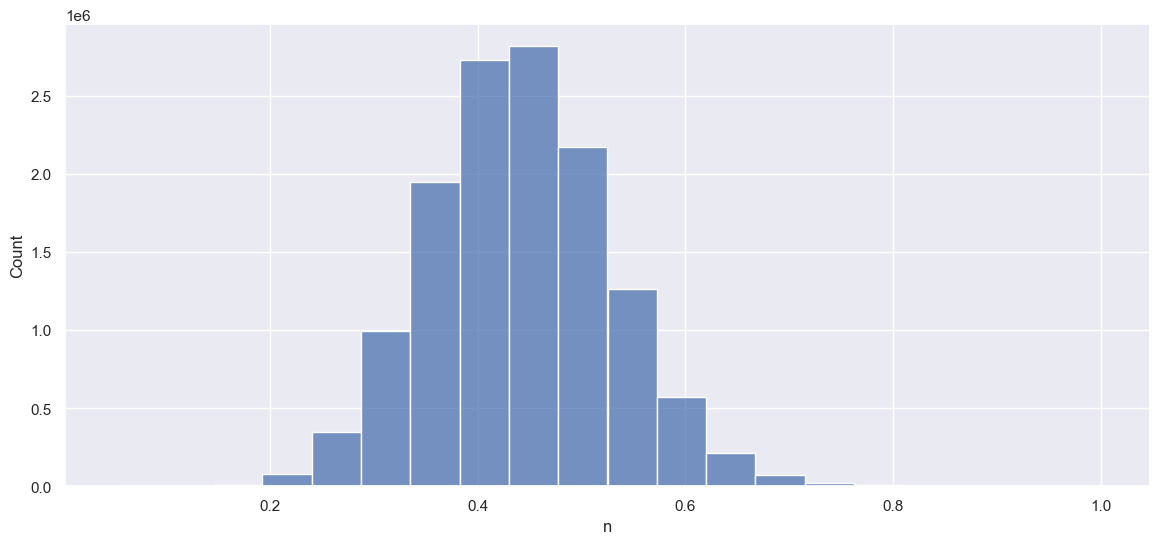

In [322]:
sns.histplot(twenty_confs.n / 20, bins=20)
plt.show()

### Overview

In [337]:
pd.DataFrame(
{ 
    "order" : [ len(petersen_confs), len(twenty_confs) ],
    "avg out degree": [ petersen_confs.n.mean(), twenty_confs.n.mean()], 
    "densitity" : [ petersen_confs.n.mean() /10, twenty_confs.n.mean() / 20 ],
},
index=['Petersen', 'Twenty'],
)

,order,avg out degree,densitity
Petersen,2613,4.554152,0.455415
Twenty,13238551,8.726316,0.436316


# Stationary Distribution

The following computes the stationary distribution of the *discrete* time Markov chain. Note, that
the (right) stochastic matrix of the Markov chain is irreducible.

We only count how often configurations are visited and how many chains are minable in each step.

However, the system remains varying amounts of times in those configurations. 
In fact, the time that is spent in a given configuration is proportional to the number of
minable chains.

In [576]:
def sparse_transition_matrix(confs):
    n = len(confs)
    t = sp.sparse.lil_array((n,n), dtype=np.float64)
    t.rows = np.array(confs['transitions'])
    t.data = confs['n'].apply(lambda x: list(np.full(x, 1 / x, dtype=np.float64))).to_numpy()
    return t


def get_stationary(T, n = 1000):
    d = T.shape[0]
    pi = np.full((1, d), 1 / d, dtype=np.float64)
    i = 0
    while i < n:
        new_pi = T @ pi.T
        # if np.allclose(pi, new_pi, atol=1e-10, rtol=1e-10):
        # if np.abs(pi - new_pi).max() < 1e-10:
        #     print('done')
        #     return new_pi[0] 
        pi = new_pi.T
        i += 1
    return pi[0]


In [546]:
stm = sparse_transition_matrix(petersen_confs).tocsc()
%time petersen_confs['pi'] = get_stationary(stm, n = 2000)
petersen_confs.groupby('n')[['pi']].sum()

CPU times: user 62.5 ms, sys: 661 µs, total: 63.2 ms
Wall time: 64.1 ms


,pi
n,
1,0.018846
2,0.048063
3,0.115250
4,0.243113
5,0.323074
6,0.147956
7,0.064674
8,0.024312
9,0.011465


In [549]:
twenty_tm = sparse_transition_matrix(twenty_confs)

In [550]:
twenty_tm_csc = twenty_tm.tocsc()

In [551]:
twenty_tm_csr = twenty_tm.tocsr() # this seems to be faster

In [589]:
%time twenty_confs['pi'] = get_stationary(twenty_tm_csr, n = 100)

CPU times: user 7.79 s, sys: 326 ms, total: 8.11 s
Wall time: 8.41 s


In [590]:
twenty_confs.groupby('n')[['pi']].sum()

,pi
n,
1,1.510739e-06
2,5.363125e-05
3,7.659449e-04
4,5.794063e-03
5,2.605149e-02
6,7.501199e-02
7,1.470055e-01
8,2.059734e-01
9,2.128027e-01


## Sampling

We use the explicitly computed stationary distribution for the Petersen graph to validate how well distributions of configurations can be sampled.

In [595]:
# This code is probably not efficient for larger graphs
def sample(g, n):
    c = HeightDifferenceVector.initial(g)
    r = np.zeros(n, dtype=np.uint64)
    for i in range(n):
        m = HeightDifferenceVector.minable(g, c)
        r[i] = len(m)
        i = np.random.choice(m)
        c = HeightDifferenceVector.mine(g, c, i)
    return r

In [596]:
def run_samples(graph, ns):
    g = mk_graph(graph)
    hists = pd.DataFrame(index=range(1,g.shape[0]+1))
    stats = pd.DataFrame(index=['n', 'mean', 'std'])
    for i in ns:
        l = f"e{i}"
        print(f"{l}", end=' ')
        r = sample(g, 10**i)
        hists[l] = pd.Series(r).value_counts(normalize=True,sort=False)
        stats[l] = [len(r), r.mean(), r.std()]
    return hists, stats

In [597]:
def plot_columns(df):
    x = df.reset_index().melt(id_vars='index', var_name='n', value_name='p')
    sns.barplot(data=x, x='index', y='p', hue='n')

### Sample Petersen Graph

In [598]:
petersen_hists, petersen_stats = run_samples(graphs.Petersen, [3,4,5,6,7])
petersen_stats

e3 e4 e5 e6 e7 

,e3,e4,e5,e6,e7
n,1000.000000,10000.00000,100000.000000,1000000.000000,1.000000e+07
mean,4.793000,4.76010,4.713270,4.724294,4.717513e+00
std,1.542774,1.53315,1.508229,1.517320,1.514381e+00


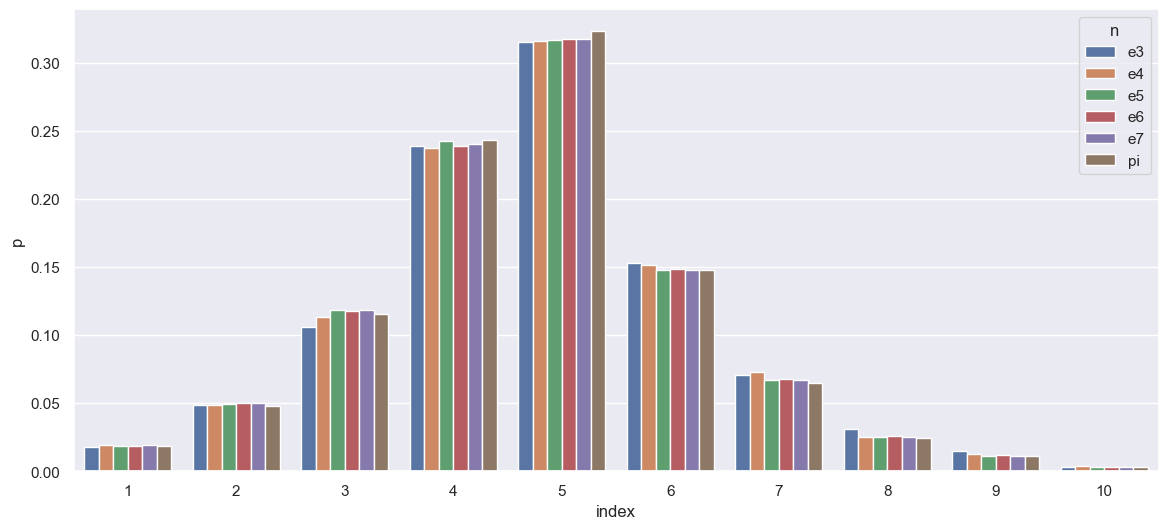

In [599]:
petersen_hists['pi'] = petersen_confs.groupby('n')['pi'].sum()
plot_columns(petersen_hists)

We can conclude that sampling works reasonable well for the Petersen graph if the size of the sample is on the order of the number configurations.

### Sample Twenty Chain Graph

In [600]:
twenty_hists, twenty_stats = run_samples(graphs.Twenty, [4,5,6,7])
twenty_stats

e4 e5 e6 e7 

,e4,e5,e6,e7
n,10000.000000,100000.000000,1000000.000000,1.000000e+07
mean,8.239200,8.348840,8.292393,8.291822e+00
std,2.258093,2.174813,2.191469,2.188144e+00


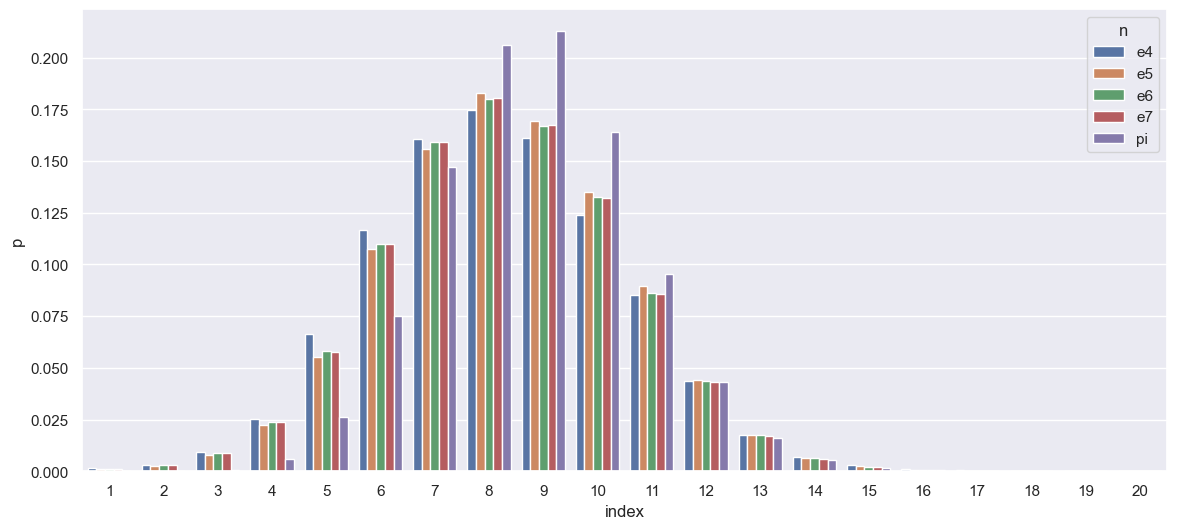

In [601]:
twenty_hists['pi'] = twenty_confs.groupby('n')['pi'].sum()
plot_columns(twenty_hists)

TODO: explain the discrepancy between the sampled distribution and the computed stationary distribution of the Markov chain.

One explanation would be if the stochastic matrix is reducible (i.e. contained states that are not reachable from the initial distribution.)
However, we proved that the chain is irreducible, by showing that the initial configuration is reachable from each configuration
that is reachable from the intial configuration.

### Sample Hoffman-Singleton Graph

We cannot compute the statonary distribution explicitely from the transition matrix for larger graphs. Instead we verify that random sampling
results in stable results.

In [28]:
hoffman_hists, hoffman_stats = run_samples(graphs.HoffmanSingleton, [5,6,7])
hoffman_stats

e5 e6 e7 

,e5,e6,e7
n,100000.000000,1000000.000000,1.000000e+07
mean,16.916790,16.942505,1.695581e+01
std,5.232413,5.158267,5.166358e+00


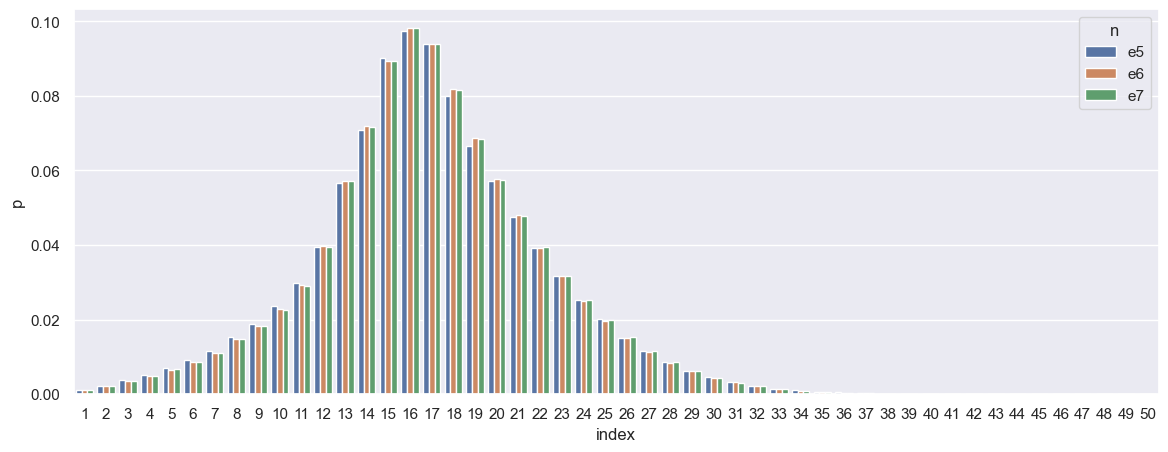

In [29]:
plot_columns(hoffman_hists)

### Sample D4K4 Graph

In [30]:
d4k4_hists, d4k4_stats = run_samples(graphs.D4K4, [5,6,7])
d4k4_stats

e5 e6 e7 

,e5,e6,e7
n,100000.000000,1000000.000000,1.000000e+07
mean,32.457870,32.585851,3.255728e+01
std,6.336102,6.119345,6.087114e+00


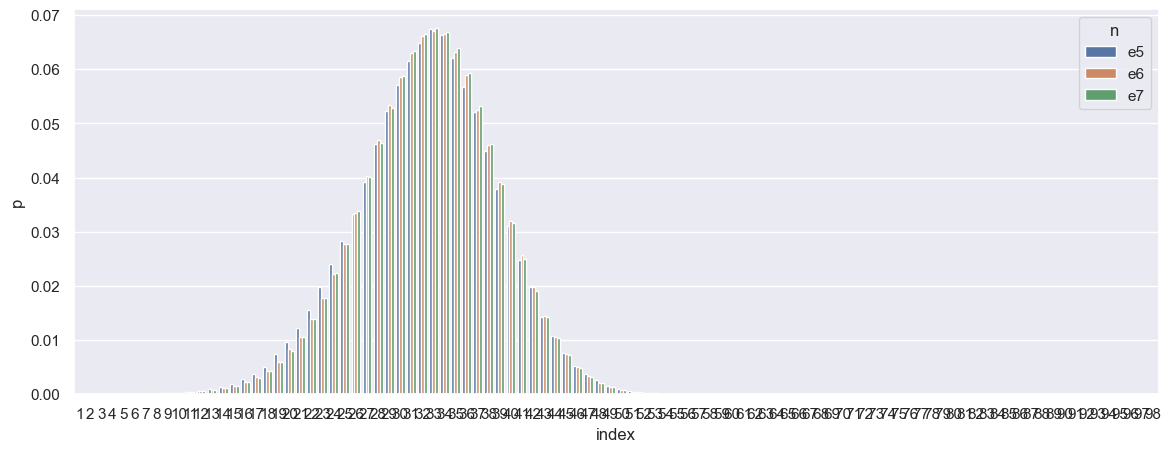

In [31]:
plot_columns(d4k4_hists)

## Continuous-time Stationary Distribution



The time that is spent in a given configuration is proportional to the number of minable chains
in that configuration.
Also all minable chains are mined all at the same rate and thus the transition relation is locally uniform.

We can therefore derive the stationary distribution for the continuous time Markov chain directly from
the stationary distribution of the discrete Markow chain.

In [32]:
def ctmc(series):
    r = pd.DataFrame({'discrete' : series})
    t = r['discrete'] * r.index
    r['continuous']= t / t.sum()
    return r

In [47]:
r = ctmc(d4k4_hists['e7'])
r

,discrete,continuous
1,3.300000e-06,1.013598e-07
2,8.600000e-06,5.282996e-07
3,1.650000e-05,1.520397e-06
4,2.790000e-05,3.427805e-06
5,4.690000e-05,7.202690e-06
...,...,...
94,1.000000e-07,2.887219e-07
95,1.000000e-07,2.917934e-07
96,1.000000e-07,2.948649e-07
97,1.000000e-07,2.979364e-07


In [37]:
ctmcs = {
    'petersen': ctmc(petersen_hists['e7']),
    'twenty': ctmc(twenty_hists['e7']),
    'hoffman': ctmc(hoffman_hists['e7']),
    'd4k4': ctmc(d4k4_hists['e7']),
}

In [63]:
r = pd.DataFrame(columns=['continuous mean', 'continuous percent', 'discrete mean', 'discrete percent'])
for n,d in ctmcs.items():
    contmean = (d['continuous'] * d.index).sum()
    contpercent = 100 * contmean / d.index.max()
    discmean = (d['discrete'] * d.index).sum()
    discpercent = 100 * discmean / d.index.max()
    r.loc[n] = [contmean, contpercent, discmean, discpercent]
r

,continuous mean,continuous percent,discrete mean,discrete percent
petersen,5.205213,52.052131,4.718741,47.187411
twenty,8.876540,44.382702,8.300088,41.500441
hoffman,18.529978,37.059955,16.955812,33.911624
d4k4,33.695367,34.383027,32.557281,33.221716


The number of minable chains at any moment in (real) time:

We notice, that compared to the discrete time distribution the continuous time distribution
is shifted slightly towards a larger number of minable chains. Intuitively, the systems move
out of configurations with a smaller number of minable chains more quickly and remains longer
in configurations with a larger number of minable chains.

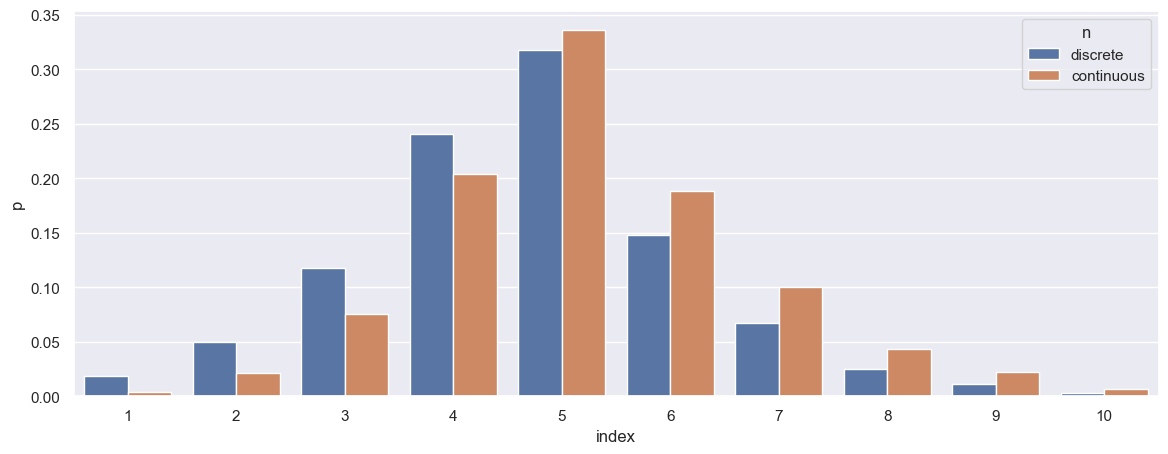

In [55]:
plot_columns(ctmcs['petersen'])

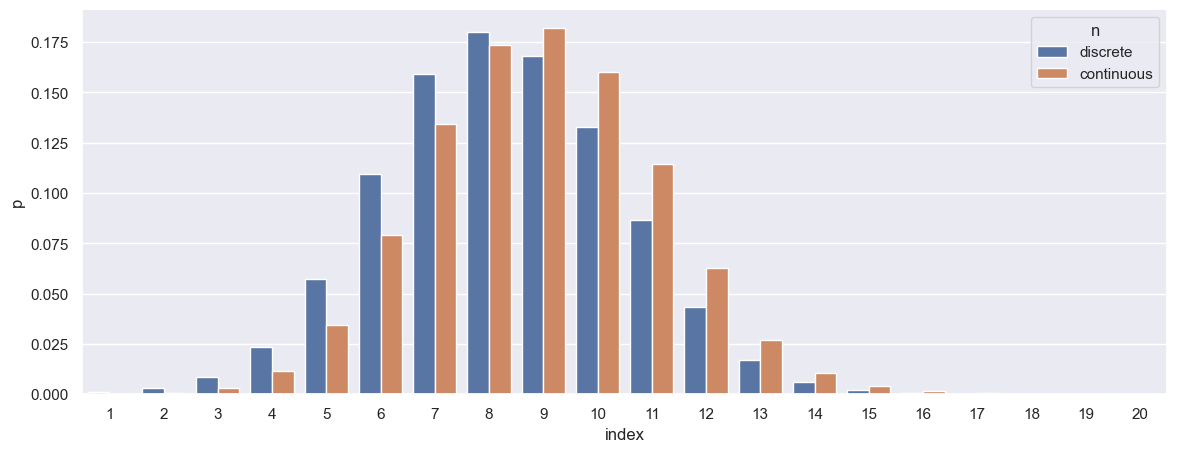

In [56]:
plot_columns(ctmcs['twenty'])

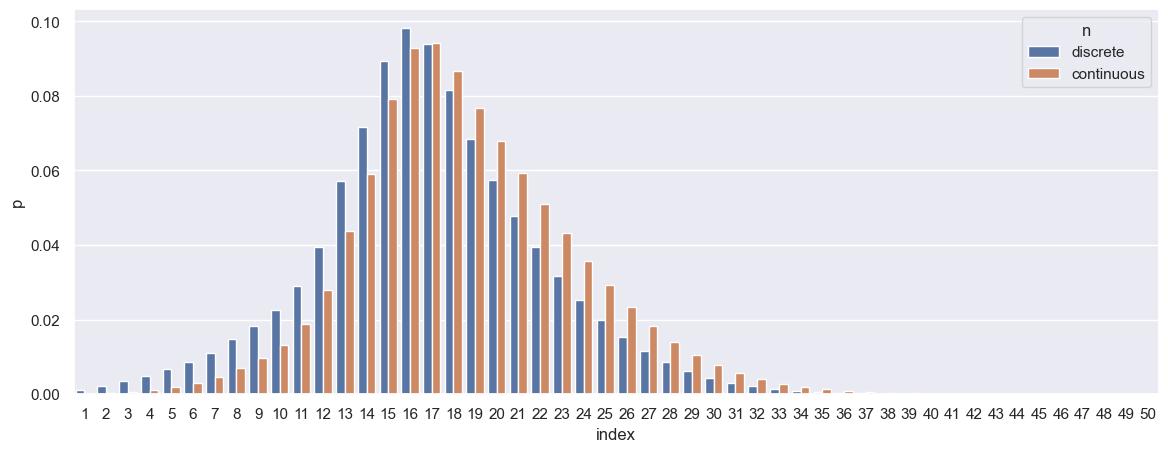

In [57]:
plot_columns(ctmcs['hoffman'])

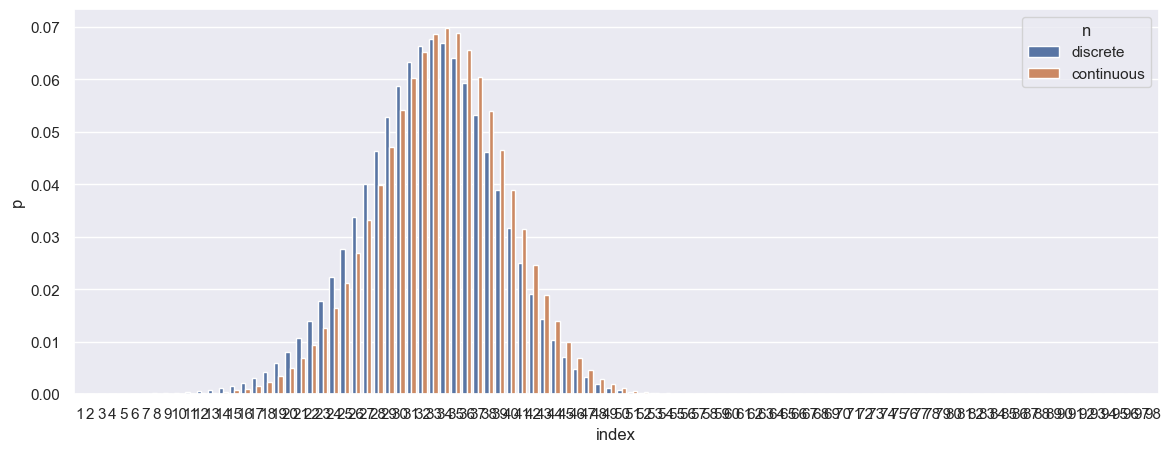

In [58]:
plot_columns(ctmcs['d4k4'])

# Discussion

How can these results be explained?

The more chains are minable the "flatter" a configuration is. The empty configuration is the optimum. The more spiky a configuration is the
less chains are minable. It seems that with larger graphs configurations are less flat and more spiky. 

It is not clear what role the diameter and the degree (and possibly other parameters) of the graph play.

# Appendix

## Alternative Implemenations of Configurations

### Height Difference Matrix Representation

In [ ]:
# This implementation encodes configurations as height difference matrixes. This means
# that the chain graph can not recovered from the configuration. As a consequence
# the mine function does not need to be aware of the graph and in turn the mineable
# function guarantees that all transitions satisfy the graph constraints.
#
# In concrete, the mineable function which is not called in the inner loop is more
# complex and the mine function in the inner loop is simpler. On the flip side
# configuration matrixes are not boolean and not sparse any more. Also values can
# be negative.
#
# Matrixes in this encoding are skew symmetric, but the implementaiton does
# not exploit that fact.
# 
# This encoding is more intuitive and, in theory, more efficient and dense # matrixes. 
#
# In practice, performance is almost identical with the sparse implementation.
#

# In this representation the full matrix can be recovered from a single row and/or
# column. (what does this mean algebraically?)
# For hashing it is thus sufficient to use only a single row.

class HeightDifferenceMatrix(Implementation):

    @staticmethod
    def mk_graph(graph):
        return mk_graph(graph)

    @staticmethod
    def hash(c):
        return hash(c[0].data.tobytes())

    @staticmethod
    def initial(g):
        return init_conf2(g)

    @staticmethod
    def minable(g, c):
        return ((c * g).max(axis=1) < 1).nonzero()[0]

    @staticmethod
    def mine(_g, c, i):
        r = c.copy()
        r[i,:] += 1
        r[:,i] -= 1
        return r

In [ ]:
%time petersen_confs_hdm = mk_transitions(HeightDifferenceMatrix, graphs.Petersen, cache_suffix='petersen_hdm', cache_refresh=True)
len(petersen_confs_hdm)

CPU times: user 195 ms, sys: 20.4 ms, total: 216 ms
Wall time: 203 ms


2613

In [ ]:
petersen_confs_hdm['maxdiff'] = petersen_confs_hdm['conf'].apply(lambda x: x[0].max())
petersen_confs_hdm['stddiff'] = petersen_confs_hdm['conf'].apply(lambda x: x[0].std())
petersen_confs_hdm['diff0'] = petersen_confs_hdm['conf'].apply(lambda x: x[0][0])

In [ ]:
# Generating the data takes about 3min.
# Storing the 1.4GB of data to disk takes 20min.
# Loading the data from disk takes about 50s.
# Python is just very, very flow :-(
%time twenty_confs_hdm = mk_transitions(HeightDifferenceMatrix, graphs.Twenty, cache_suffix='twenty_hdm', cache_refresh=True)
len(twenty_confs_hdm)

CPU times: user 43.6 s, sys: 2.59 s, total: 46.2 s
Wall time: 47.4 s


In [ ]:
# takes about 3 min (should we cache it, too?)
twenty_confs_hdm['maxdiff'] = twenty_confs_hdm['conf'].apply(lambda x: x[0].max())
twenty_confs_hdm['stddiff'] = twenty_confs_hdm['conf'].apply(lambda x: x[0].std())
twenty_confs_hdm['diff0'] = twenty_confs_hdm['conf'].apply(lambda x: x[0][0])

13238551

In [ ]:
petersen_confs_hdm.groupby('maxdiff').agg({'n':'mean', 'maxdiff': 'count'})

,n,maxdiff
maxdiff,,
0,5.106933,851
1,4.471539,1423
2,3.513274,339


In [ ]:
petersen_confs_hdm.groupby('n').agg({'maxdiff':'count', 'stddiff':'mean'})

,maxdiff,stddiff
n,,
1,10,0.670820
2,105,0.685947
3,420,0.653692
4,790,0.591592
5,732,0.519301
6,360,0.485747
7,140,0.449213
8,45,0.400000
9,10,0.300000


In [ ]:
twenty_confs_hdm.groupby('maxdiff').agg({'n':'mean', 'maxdiff': 'count'})

NameError: name 'twenty_confs' is not defined

In [ ]:
twenty_confs_hdm.groupby('n').agg({'maxdiff':'count', 'stddiff':'mean'})

,hash,stddiff
n,,
1,20,1.254990
2,710,1.254051
3,10140,1.213092
4,76705,1.152181
5,344884,1.086659
6,993050,1.025149
7,1946140,0.970241
8,2726790,0.920459
9,2817200,0.873257


In [ ]:
petersen_confs_hdm.maxdiff.mean(), twenty_confs.maxdiff.mean()

AttributeError: 'DataFrame' object has no attribute 'maxdiff'

### Dependency DAG Representation

A configuration is represented as a matrix that encodes the dependency DAG.

Mining a chain means to remove all existing dependencies on the edge and
create dependencies to those neighouring chains that had no dependency before.

More formally, we

1. add an outgoing egde for all neighbours without incoming edge and
2. remove all incoming edges.


In [ ]:
class DependencyDAG(Implementation):
    @staticmethod
    def mk_graph(graph):
        return mk_graph(graph)

    @staticmethod
    def hash(c):
        return hash_conf(c)

    @staticmethod
    def initial(g):
        return init_conf2(g)

    @staticmethod
    def minable(_g, c):
        return (c.sum(axis=1) == 0).nonzero()[0]

    @staticmethod
    def mine(g, c, i):
        r = c.copy()
        # set r[i,:] (outgoing edges) to g[:,i] - r[:,i] (create edge if there was no incoming edge)
        r[i,:] = g[i,:] - r[:,i] # xor, assume that r[i] <= g[i]
        # remove all entries from the column i (incoming edges)
        r[:,i] = 0
        return r

In [ ]:
%time petersen_confs_dag = mk_transitions(DependencyDAG, graphs.Petersen, cache_suffix='petersen_dag', cache_refresh=False)
len(petersen_confs_dag)

CPU times: user 5.86 ms, sys: 1.1 ms, total: 6.96 ms
Wall time: 6.18 ms


2613

### BitPacked DAG Representation

Using bit packed arrays to represent the configurations saves a lot of memory but overall takes more time to compute the graph, most likely to the
extra arithmatic and unpacking required for column slicing. It seems that those operations are not efficiently vectorized.
Overall, the computation of the automaton takes about twice as long as with the unpacked matrix representation.

In [ ]:
class SparseBitPackedDAG(Implementation):
    @staticmethod
    def mk_graph(graph):
        # bit packed sparse matrix. Trailing bits are always 0
        return np.packbits(mk_graph(graph), axis=1, bitorder='big')

    @staticmethod
    def hash(c):
        return hash_conf(c)

    @staticmethod
    def initial(g):
        return np.packbits(init_conf2(g), axis=1)

    @staticmethod
    def minable(_g, c):
        return (c.sum(axis=1) == 0).nonzero()[0]

    @staticmethod
    def mine(g, c, i):
        r = c.copy()
        # get column i as packed bit vector
        ci = np.packbits((c[:,i // 8] >> (7 - i % 8)) & 0x01)
        r[i,:] = g[i,:] ^ ci # xor, assume that r[i] <= g[i]
        r[:,i // 8] = r[:,i // 8] & np.uint8(0xff & (0xff7f >> (i % 8)))
        return r

def from_bconf(bconf):
    return np.unpackbits(bconf, axis=1, count=bconf.shape[0], bitorder='big')

In [ ]:
%time petersen_confs_packed = mk_transitions(SparseBitPackedDAG, graphs.Petersen, cache_suffix='petersen_packed', cache_refresh=False)
len(petersen_confs_packed)

CPU times: user 6.55 ms, sys: 1 ms, total: 7.55 ms
Wall time: 6.56 ms


2613

### Sparse Matrix DAG Representation

Using sparse matrix representations is prohibitively slow. The problem is that the implementation requires both column and row slicing.

In [ ]:
class SparseDAG(Implementation):
    @staticmethod
    def mk_graph(graph):
        # row compressed sparse matrix
        return sp.sparse.csr_array(mk_graph(graph), dtype=np.int8)

    @staticmethod
    def hash(c):
        return hash_conf(c)

    @staticmethod
    def initial(g):
        return sp.sparse.csr_array(init_conf2(g))

    @staticmethod
    def minable(_g, c):
        return (c.sum(axis=1) == 0).nonzero()[0]

    # This is prohibitively slow!
    @staticmethod
    def mine(g, c, i):
        r = c.copy()
        r[[i],:] = g[[i],:] - r[:,[i]].T # column slicing is expensive in csr arrays
        r[:,[i]] = 0
        return r

In [ ]:
%time petersen_confs_sparse = mk_transitions(SparseDAG, graphs.Petersen, cache_suffix='petersen_sparse', cache_refresh=False)
len(petersen_confs_sparse)

CPU times: user 76.6 ms, sys: 2.21 ms, total: 78.8 ms
Wall time: 81.7 ms


5226

## Test Different Implementations

In [ ]:
def test(g, c, v):
    x = c
    for i in v:
        x = mine(g, x, i)
    return x
def btest(g, c, v):
    x = c
    for i in v:
        x = bmine(g, x, i)
    return x
def stest(g, c, v):
    x = c
    for i in v:
        x = smine(g, x, i)
    return x


In [ ]:
v = [0,1,2,3,4,5,6,7,8,9,10,11,8,12,7,13,3,14,0,15,2,16,1,17,4,18,5,19,6]
{ 
    "b" : (test(g, init_conf(g), v) == from_bconf(btest(bg, init_bconf(bg), v))).all(),
    "s" : (test(g, init_conf(g), v) == stest(sg, init_sconf(sg), v)).all(),
}

True

## Double Check Soundness of Construction:

In [223]:
{
    1 : sp.special.comb(10,1),
    2 : sp.special.comb(10,2) + 10 * 6, # all pairs at same level + all paris at different levels
    3 : (sp.special.comb(10,2) + 10 * 6) * 4, # all pairs at all levels combined with one more minable node (not dependent on the previous)
}

{1: 10.0, 2: 105.0, 3: 420.0}

In [224]:
x = pd.DataFrame([(k, v[0], v[1], len(v[1])) for k,v in petersen_confs.items()], columns=['hash', 'conf', 'transitions', 'n'])
x2 = x.query('n == 2').copy()

In [225]:
x2['m'] = x2.conf.copy().apply(lambda c: minable(c))
x2['mstr'] = x2.m.apply(lambda m: str(m))
x2

,hash,conf,transitions,n,m,mstr
1942,-7930659089034126825,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, ...","[-8041120012655694383, -2617471991899097155]",2,"[7, 9]",[7 9]
1960,2250447209038754865,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, ...","[4072669502136434950, -3037203631758632283]",2,"[6, 9]",[6 9]
1962,-5619004480391568259,"[[0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, ...","[4008133401097849616, -5293219120899729222]",2,"[6, 8]",[6 8]
2016,-2479906091558450084,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, ...","[5122700977348441491, -291767812445952893]",2,"[5, 8]",[5 8]
2022,-926569847930216703,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, ...","[-6938856788005399257, -1899546351885497704]",2,"[5, 7]",[5 7]
...,...,...,...,...,...,...
2598,5634579442942498392,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, ...","[5326096572390618375, -4026445027915929042]",2,"[0, 8]",[0 8]
2599,-3555244834660322828,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, ...","[984269184280173841, -4026445027915929042]",2,"[0, 4]",[0 4]
2600,2071775719526421037,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, ...","[8032205725759801205, -4026445027915929042]",2,"[0, 7]",[0 7]
2601,-2020393736945699039,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, ...","[5263160615336228945, -4026445027915929042]",2,"[0, 6]",[0 6]


In [226]:
import igraph as ig

In [227]:
for i in x2.query('mstr == "[0 1]"').conf[0:2]:
    print("---------------------------")
    for j in range(10):
        print(f"{j}: {str(i[j].nonzero()[0])}")

---------------------------
0: []
1: []
2: [0]
3: [0 1]
4: [1]
5: [0]
6: [1]
7: [2 6]
8: [3]
9: [4 5]
---------------------------
0: []
1: []
2: [0 4]
3: [1]
4: [1]
5: [0 6]
6: [1]
7: [6]
8: [3]
9: [4]


In the second configuration 0 and 1 are on different levels.

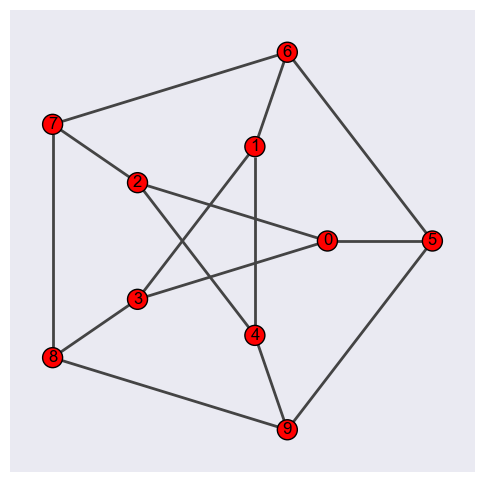

In [228]:
plt.rcParams["figure.figsize"] = [6,6]
fig, ax = plt.subplots()
label = [str(i) for i in range(10)]
g = graphs.Petersen.simplify()
g.to_undirected(mode="collapse")
ig.plot(
    g,
    vertex_size=20,
    vertex_label=label,
    target=ax,
    layout=graphs.Petersen_Layout,
)
plt.show()